In [2]:
import itertools
import numpy as np
import random
import pickle
import matplotlib.pyplot as plt
from math import *
import scipy
from tqdm import tqdm

from utils import *
from ODE_utils import *

import matplotlib as mpl
import pandas as pd
import multiprocessing

# Set the default font and size
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['font.size'] = 16

In [3]:
class SeqUt_alt: # sequential utilizer
    def __init__(self, rho, g_enz, gC, pref_list, biomass, id):
        '''
        growth_Rate_list_single: float array[N_res], generated from gaussian
        pref_list: int array[N_res]
        biomass: float
        '''
        self.cat = "Seq"
        self.id = id
        self.gC = gC
        self.rho = rho
        self.alive = True
        self.nr = len(g_enz)
        self.g = g_enz # g here is already converted from gaussian and by Terry's physiology
        self.pref = pref_list
        self.b = biomass
        self.eating = np.array([False for i in range(self.nr)]) # default - not eating anything
        self.inlag = False
    def Dilute(self, D):
        '''
        D: float
        '''
        self.b /= D
        if(self.b<DIEOUT_BOUND):
            self.alive = False
    def GetEating(self, Rs):
        '''
        Rs: float array of all resources
        '''
        self.eating = np.array([False for i in range(self.nr)])
        for r in self.pref:
            if(Rs[r-1]>0):
                self.eating[r-1] = True
                break
    def GetGrowthRate(self):
        n = len(self.g)
        gtilde = self.g * (self.rho + (1-self.rho)*n)
        return (gtilde/(1+gtilde/self.gC)) @ self.eating
    def GetDep(self):
        '''
        In all cases assume yield Y=1
        '''
        return self.eating.astype(float)
    

class CoUt_alt: # coutilizer
    def __init__(self, rho, g_enz, gC, biomass, id):
        '''
        growth_Rate_list_single: float array[1, N_res]
        gC: float
        biomass: float
        '''
        self.cat = "Cout"
        self.id = id
        self.rho = rho
        self.alive = True
        self.nr = len(g_enz)
        self.g = g_enz # g here is already converted from gaussian and by Terry's physiology
        self.gC = gC
        self.b = biomass
        self.eating = np.array([False for i in range(self.nr)]) # default - not eating anything
        self.inlag = False
    def Dilute(self, D):
        '''
        D: float, dilution factor
        '''
        self.b /= D
        if(self.b<DIEOUT_BOUND):
            self.alive = False
    def GetEating(self, Rs):
        '''
        Rs: float array of all resources
        '''
        self.eating = (Rs>0)
    def GetGrowthRate(self): # growth rate of the sepcies with non-zero resources in R_left
        g_vec = self.g[self.eating]
        n = len(self.g)
        n_eat = np.sum(self.eating)
        if(True not in self.eating):
            return 0
        else:
            return ( ( np.sum(g_vec) * (self.rho*n_eat + (1-self.rho)*n)/n_eat )**-1 + 1/self.gC )**-1
    def GetDep(self):
        '''
        In all cases assume yield Y=1
        Get the fraction of each resource in the biomass gained by this co-utilizer
        '''
        dep = np.zeros(self.nr)
        dep[self.eating] = self.g[self.eating]/np.sum(self.g[self.eating])
        return dep

In [6]:
# load the data and make the plot
R = 4
path = "../../ODE-related/seq_vs_co_0213"
path_new = "../../ODE-related/seq_vs_co_0213_vary_D"
rhos = np.linspace(0, 0.4, 51)
# get the result for pairwise
all_frac_diaux_pair = []
D_list = [10, 100, 1000]
for D in D_list:
    frac_diaux_pair = []
    for rho in tqdm(rhos):
        if(D==100):
            data = pickle.load(open(os.path.join(path, f"pairwise_rho={rho}.pkl"), "rb"))
        else:
            data = pickle.load(open(os.path.join(path_new, f"pairwise_rho={rho}_D={D}.pkl"), "rb"))
        basic = data["basic"]
        _, gC, Nseq, Ncout = basic["D"], basic["gC"], basic["Nseq"], basic["Ncout"]
        states = data["end"]["states"]
        ids = [i["ids"] for i in states]
        ids_list = sum(ids, [])
        frac_diaux_pair.append(len([i for i in ids_list if i<Nseq])/len(ids_list))
    all_frac_diaux_pair.append(frac_diaux_pair)

100%|██████████| 51/51 [00:03<00:00, 15.65it/s]


In [7]:
R = 4
path = "../../ODE-related/seq_vs_co_0213"
path_new = "../../ODE-related/seq_vs_co_0213_vary_D"
rhos = np.linspace(0, 0.4, 51)
# get the result for pairwise
all_frac_diaux = []
D_list = [10, 100, 1000]
for D in D_list:
    frac_diaux = []
    for rho in tqdm(rhos):
        if(D==100):
            data = pickle.load(open(os.path.join(path, f"full_rho={rho}.pkl"), "rb"))
        else:
            data = pickle.load(open(os.path.join(path_new, f"full_rho={rho}_D={D}.pkl"), "rb"))
        basic = data["basic"]
        _, gC, Nseq, Ncout = basic["D"], basic["gC"], basic["Nseq"], basic["Ncout"]
        states = data["end"]["states"]
        ids = [i["ids"] for i in states]
        ids_list = sum(ids, [])
        frac_diaux.append(len([i for i in ids_list if i<Nseq])/len(ids_list))
    all_frac_diaux.append(frac_diaux)

100%|██████████| 51/51 [00:54<00:00,  1.08s/it]


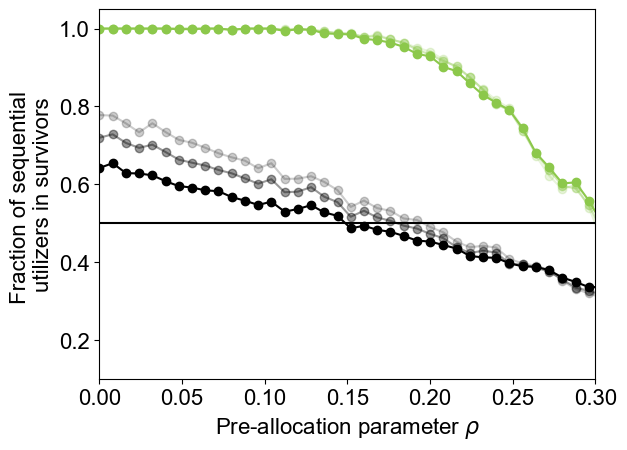

In [8]:
alist = [1.0, 0.4, 0.2]
for idx, frac_diaux_pair in enumerate(all_frac_diaux_pair):
    plt.plot(rhos, frac_diaux_pair, marker="o", c="k", alpha = alist[idx])
for idx, frac_diaux in enumerate(all_frac_diaux):
    plt.plot(rhos, frac_diaux, marker="o", c="#8CC84B", alpha=alist[idx])

plt.xlabel("Pre-allocation parameter $\\rho$")
plt.ylabel("Fraction of sequential \nutilizers in survivors")
plt.xlim(0, 0.3)
plt.ylim(0.1, 1.05)
plt.axhline(0.5, c='k')

# plt.savefig("figs/pairwise_vs_community_lag.pdf")

In [ ]:
# D increases, first niche domination strengthens, diauxers gets better off